<a href="https://colab.research.google.com/github/drifterz13/pikachu-raichu-mimikyu/blob/main/pikachu_raichu_mimikyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we're going to scrape data from duckduckgo.

In [ ]:
pip install duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.6 MB/s eta 0:00:00


In [ ]:
from duckduckgo_search import AsyncDDGS
import asyncio
import aiohttp
from aiohttp import ClientSession
import os

dir_name = '/content/pokemons'
max_results = 160

In [ ]:
async def scraped_images(keyword):
    urls = []
    async with AsyncDDGS() as ddgs:
        async for r in ddgs.images(keyword, max_results=max_results):
            image_url = r['image']
            urls.append(image_url)

    return urls

In [ ]:
async def download_images(session: ClientSession, url, fname):
    print(f'Downloading: {fname}')

    try:
        async with session.get(url, timeout=5) as resp:
            if resp.status == 200:
                with open(f'{dir_name}/{fname}', 'wb') as f:
                    async for data in resp.content.iter_any():
                        f.write(data)
            else:
                print(f'Error code {resp.status}: {resp.content}')

    except Exception as e:
        print(f'An error occured: {e}')

In [ ]:

async def get_dataset():
    os.makedirs(dir_name, exist_ok=True)
    search_terms = ['pikachu', 'raichu', 'mimikyu']

    for term in search_terms:
        os.makedirs(f'{dir_name}/{term}', exist_ok=True)

    for term in search_terms:
        results = await scraped_images(term)

        async with aiohttp.ClientSession() as session:
            tasks = []

            for idx, url in enumerate(results):
                fname = f'{term}/{term}_{idx}.jpg'
                task = download_images(session, url, fname)
                tasks.append(task)
            await asyncio.gather(*tasks)

In [ ]:
await get_dataset()

Once we got the data, we will setup faskbook and cleanup invalid data.

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

Let's check some sample images.

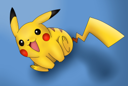

In [ ]:
path = Path('/content/pokemons')
pika_im = Image.open(path/'pikachu/pikachu_0.jpg')
pika_im.to_thumb(128,128)

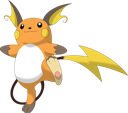

In [ ]:
path = Path('/content/pokemons')
raichu_im = Image.open(path/'raichu/raichu_0.jpg')
raichu_im.to_thumb(128,128)

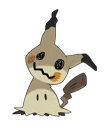

In [ ]:
path = Path('/content/pokemons')
mimikyu_im = Image.open(path/'mimikyu/mimikyu_0.jpg')
mimikyu_im.to_thumb(128,128)

Next, we're gonna verify images.

In [ ]:
fns = get_image_files(path)
fns

(#454) [Path('/content/pokemons/mimikyu/mimikyu_88.jpg'),Path('/content/pokemons/mimikyu/mimikyu_29.jpg'),Path('/content/pokemons/mimikyu/mimikyu_50.jpg'),Path('/content/pokemons/mimikyu/mimikyu_147.jpg'),Path('/content/pokemons/mimikyu/mimikyu_137.jpg'),Path('/content/pokemons/mimikyu/mimikyu_139.jpg'),Path('/content/pokemons/mimikyu/mimikyu_67.jpg'),Path('/content/pokemons/mimikyu/mimikyu_143.jpg'),Path('/content/pokemons/mimikyu/mimikyu_32.jpg'),Path('/content/pokemons/mimikyu/mimikyu_120.jpg')...]

In [ ]:
failed = verify_images(fns)
failed

(#3) [Path('/content/pokemons/mimikyu/mimikyu_156.jpg'),Path('/content/pokemons/raichu/raichu_51.jpg'),Path('/content/pokemons/pikachu/pikachu_93.jpg')]

In [ ]:
failed.map(Path.unlink)

(#3) [None,None,None]

It's time to use our data!

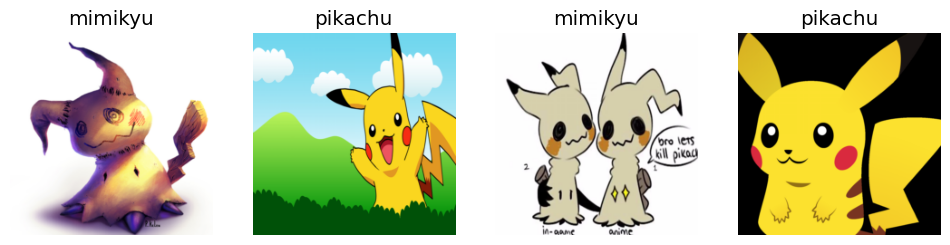

In [ ]:
pokes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = pokes.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.587594,0.362826,0.146341,01:27


epoch,train_loss,valid_loss,error_rate,time
0,0.549087,0.138273,0.060976,02:02
1,0.364197,0.025781,0.000000,02:01
2,0.282734,0.010462,0.000000,02:03
3,0.220409,0.009294,0.000000,02:00


Let's try to identify factors that cause losses during traning.

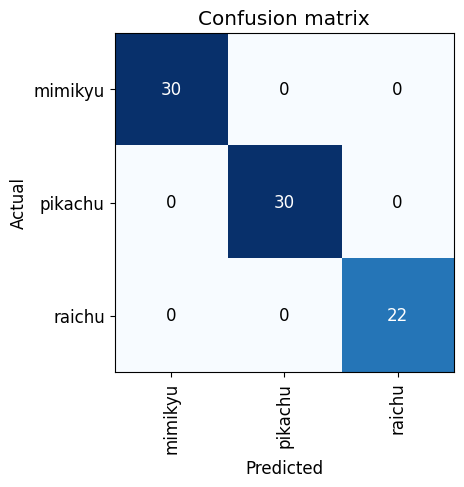

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

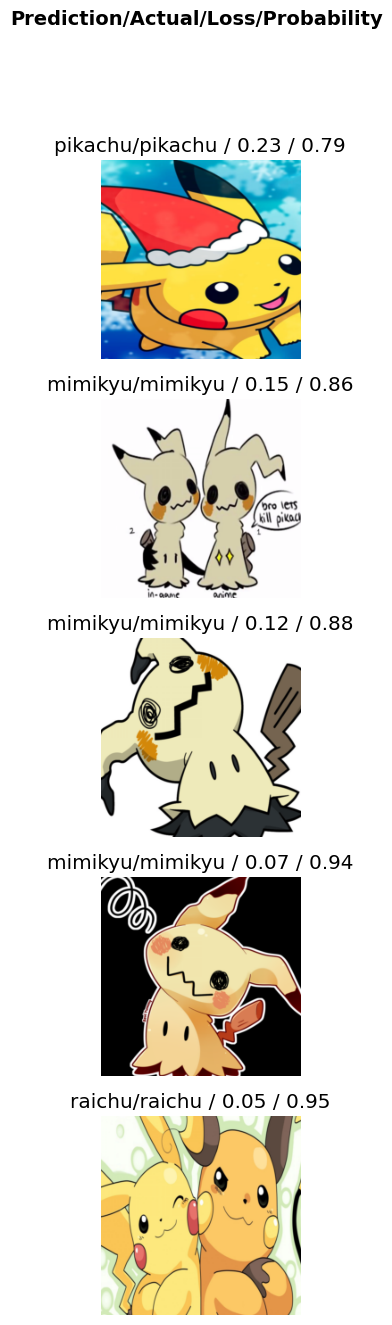

In [ ]:
interp.plot_top_losses(5, nrows=5)

Let's clean some data!

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Overall the cleaner does not show any misleadning data. We will skip cleaning process!

In [ ]:
learn.export('model.pkl')

In [ ]:
Path().ls(file_exts='.pkl')

(#1) [Path('model.pkl')]

Let's test the exported model

In [ ]:
learn_inf = load_learner(Path()/'model.pkl')

In [ ]:
learn_inf.predict('/content/pokemons/pikachu/pikachu_20.jpg')

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('pikachu', tensor(1), tensor([5.8325e-05, 9.9982e-01, 1.1775e-04]))

In [ ]:
learn_inf.dls.vocab

['mimikyu', 'pikachu', 'raichu']

We will continue building GUI for testing this model.

In [ ]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
p,p_idx,probs = learn_inf.predict(img)

In [ ]:
lb_pred = widgets.Label()
lb_pred.value = f'Prediction: {p}; Probability: {probs[p_idx]:.04f}'
lb_pred

Label(value='Prediction: pikachu; Probability: 0.9558')

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [ ]:
def on_click_classify(button):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(128,128))
  p,p_idx,probs = learn_inf.predict(img)
  lb_pred.value = f'Prediction: {p}; Probability: {probs[p_idx]:.04f}'


btn_run.on_click(on_click_classify)

In [ ]:
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select Pokemon!'), btn_upload, out_pl, btn_run, lb_pred])